# <span style="color:brown"> **UNET Segmentation TRAINING**  
### *Keras / Tensorflow<span style="color:brown">  2*

*thomas.grenier@creatis.insa-lyon.fr*


Here, we train a UNet network.
We first need to go deeper in this architecture.

### <span style="color:brown"> **UNet**
This network is fully convolutional. It uses skip connections from the encoder side to the decoder side to preserve scale information.

This basic architecture can be changed in order to best perform on your data. 
In the following figure, the UNet is a 4 stages (or levels) UNet with 32 neurons on the first layer. These two features are the most significant for this architecture.

The encoder side consists of 2 convolution layers (convolution + activation + batch normalization) at each level.
Each level has twice more neurons than the previous one.
To jump from on level to the next one, a max pooling is performed which reduces the spatial size by 4.

The decoder processes symmetrically.
At each level, the features coming from the encoder level aside is concatenated to the features coming from the lower decoder level.
Then, as for the encoder, decoder levels consist of 2 convolution layers.
To adapt the spatial size from one stage to thee next one, an upsampling is performed.
This upsampling can be done by interpolation (https://keras.io/api/layers/reshaping_layers/up_sampling2d/) or by transposed convolution (https://keras.io/api/layers/convolution_layers/convolution2d_transpose/) that someway learnt how to interpolate.

To produce the segmentation, all feature are first sumup to a *n* features map, where *n* is the number of classes, by *n* 1x1 convolution layer.
Then a *arg max* is done to produce the segmentation in the multi-classe case.
For binary segmentation, a simple threshold does the job.

<img src="figures/UNet.png" alt="UNet" style="width: 70%;"/>

In this UNet implementation, many parameters can be modified:
- The number of levels 
- The amount of feature at first level.
- Batch normalization can be activated or not
- Dropout amount (0.0 means no dropout)
- The upsampling strategy
- Activation functions
- Number of classes

Then, many hyper-parameters can be tuned for training.

In this notebook, you will train a UNet. 


### <span style="color:red"> Questions

- what was the architecture of the previously used network (in the test notebook) ? number of stages, features at first stage?...
- how many parameters have this network ?
- compare the code function *conv2d_block* of the network (located in keras_unet/models/custom_unet.py) with the network description.

## <span style="color:brown"> **1- System and basic imports**

In [1]:
import glob
import os
import sys
from datetime import datetime

from tqdm import tqdm 

import numpy as np

import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.colors import ListedColormap
%matplotlib inline
plt.rcParams["figure.figsize"] = (15,15)

import cv2
    
#prevent unwanted warning 
os.environ["TF_CPP_MIN_LOG_LEVEL"]="3" 

## <span style="color:brown"> **2- Important parameters**

In [2]:
IMG_SIZE =  96  # 96 x 96 input images

VALIDATION_RATIO = 0.1

JUPYTER_DISPLAY_ON = True # True or False used for displaying (or not) images

### Parameters to tune

In [3]:
# Network architecture related values 
NBLAYERS_UNET = 5      # <- number of levels [5]
NBFILTERS_L1_UNET = 32 # <- number of neurons for the first level [32]
DROPOUT_RATE = 0.1     # 0.0  to 1.0 [0.1]
KERNEL_SIZE = (3,3)    # (3,3)  (5,5) 
BATCHNORM_ON = False    # True or False [False]

CNN_ACTIVATION = 'relu' # relu, elu, selu, LeakyReLU, ...

# Training parameters
NBEPOCHS = 20          # Nb of Epoch  [20]
BATCH_SIZE = 16         # Number of sample in each batch (4 to 64) [16]
NBSTEPS_PER_EPOCH = 50  # nb of batches per epoch (1  to ...)  [50] (used for data augmentation)
NBPATIENCE_EPOCHS = 30  # nb of epoch after a minimum detection before stopping (early stop) [30]

### Name of the model file

In [4]:
model_path = './trained_model/'
model_name = 'Unet_1i_f' + str(NBFILTERS_L1_UNET) + '_l'+ str(NBLAYERS_UNET) +  '_k'+ str(KERNEL_SIZE[0]) + '_do' + str(DROPOUT_RATE) +'_act'+CNN_ACTIVATION + '_b' + str(BATCH_SIZE) +'_Std'
if BATCHNORM_ON == True:
    model_name = model_name + '_BN'
model_filename = model_path + model_name + '_input'+ str(IMG_SIZE) +'.h5'
print(" -> model_study : ", model_name)
print(" -> model_filename : ", model_filename)

 -> model_study :  Unet_1i_f32_l5_k3_do0.1_actrelu_b16_Std
 -> model_filename :  ./trained_model/Unet_1i_f32_l5_k3_do0.1_actrelu_b16_Std_input96.h5


## <span style="color:brown"> **3- Session launch**

In [5]:
import tensorflow as tf

print(tf.__version__)
print("Number of GPUs available : ", len(tf.config.list_physical_devices('GPU')))


2.4.1
Number of GPUs available :  1


## <span style="color:brown"> **4- Load data**

<span style="color:red">
    
**Before running the next cell**, you must have :
   1. downloaded the file ```dlss21_ho4_data.tar.gz``` 
   2. unziped the downloaded file in the directory of this notebook.
    
Data should be at ```./dlss21_ho4_data```    
    
## <span style="color:brown"> 4.1- Load files and set names

In [6]:
# train
train_masks_files     = glob.glob("./dlss21_ho4_data/train/labels/*.png")
train_images_e8_files = glob.glob("./dlss21_ho4_data/train/images/*_e8.png")
train_images_e5_files = glob.glob("./dlss21_ho4_data/train/images/*_e5.png")
train_images_e2_files = glob.glob("./dlss21_ho4_data/train/images/*_e2.png")

# test
test_masks_files     = glob.glob("./dlss21_ho4_data/test/labels/*.png")
test_images_e8_files = glob.glob("./dlss21_ho4_data/test/images/*_e8.png")
test_images_e5_files = glob.glob("./dlss21_ho4_data/test/images/*_e5.png")
test_images_e2_files = glob.glob("./dlss21_ho4_data/test/images/*_e2.png")


os.makedirs(model_path+model_name, exist_ok=True)  # save fig

logs_path = '../logs/'
os.makedirs(logs_path, exist_ok=True)  # save fig

train_images_e2_files.sort()
train_images_e5_files.sort()
train_images_e8_files.sort()
train_masks_files.sort()

test_images_e2_files.sort()
test_images_e5_files.sort()
test_images_e8_files.sort()
test_masks_files.sort()

print( " trainning :  ", len(train_images_e2_files), len(train_images_e5_files), len(train_images_e8_files), len(train_masks_files) )
print( " testing   :  ", len(test_images_e2_files), len(test_images_e5_files), len(test_images_e8_files), len(test_masks_files) )

nb_train = int( len(train_masks_files) * (1 - VALIDATION_RATIO) )

 trainning :   717 717 717 717
 testing   :   208 208 208 208


__The previous cell should output 717 as training images and 208 as testing images.
If not, you must check where the data is.__

## <span style="color:brown"> 4.2- Randomly permute the data 

In [7]:
nb_display = 10
if JUPYTER_DISPLAY_ON == True:
    print( f" -> First {nb_display} train items ")
    [print(train_images_e2_files[i], train_images_e5_files[i], train_images_e8_files[i], train_masks_files[i]) for i in range(nb_display)]

    print( f" -> Last {nb_display} train items ")
    [print(train_images_e2_files[i], train_images_e5_files[i], train_images_e8_files[i], train_masks_files[i]) for i in range( len(train_masks_files)-nb_display, len(train_masks_files) )]

# permuation of inputs
permutation_train = np.random.permutation( len(train_masks_files))

# print("Permutation : ", permutation)
train_images_e2_files_rnd=[train_images_e2_files[i] for i in permutation_train]
train_images_e5_files_rnd=[train_images_e5_files[i] for i in permutation_train]
train_images_e8_files_rnd=[train_images_e8_files[i] for i in permutation_train]
train_masks_files_rnd=[train_masks_files[i] for i in permutation_train]

if JUPYTER_DISPLAY_ON == True:
    print( f" -> First PERMUTED {nb_display} train items ")
    [print(train_images_e2_files_rnd[i], train_images_e5_files_rnd[i], train_images_e8_files_rnd[i], train_masks_files_rnd[i]) for i in range(nb_display)]

    print( f" -> Last PERMUTED {nb_display} train items ")
    [print(train_images_e2_files_rnd[i], train_images_e5_files_rnd[i], train_images_e8_files_rnd[i], train_masks_files_rnd[i]) for i in range( len(train_masks_files)-nb_display, len(train_masks_files) )]

permutation_test = np.random.permutation( len(test_masks_files))
test_images_e2_files_rnd=[test_images_e2_files[i] for i in permutation_test]
test_images_e5_files_rnd=[test_images_e5_files[i] for i in permutation_test]
test_images_e8_files_rnd=[test_images_e8_files[i] for i in permutation_test]
test_masks_files_rnd=[test_masks_files[i] for i in permutation_test]   

 -> First 10 train items 
./dlss21_ho4_data/train/images/P02_006_e2.png ./dlss21_ho4_data/train/images/P02_006_e5.png ./dlss21_ho4_data/train/images/P02_006_e8.png ./dlss21_ho4_data/train/labels/P02_006.png
./dlss21_ho4_data/train/images/P02_021_e2.png ./dlss21_ho4_data/train/images/P02_021_e5.png ./dlss21_ho4_data/train/images/P02_021_e8.png ./dlss21_ho4_data/train/labels/P02_021.png
./dlss21_ho4_data/train/images/P02_023_e2.png ./dlss21_ho4_data/train/images/P02_023_e5.png ./dlss21_ho4_data/train/images/P02_023_e8.png ./dlss21_ho4_data/train/labels/P02_023.png
./dlss21_ho4_data/train/images/P02_028_e2.png ./dlss21_ho4_data/train/images/P02_028_e5.png ./dlss21_ho4_data/train/images/P02_028_e8.png ./dlss21_ho4_data/train/labels/P02_028.png
./dlss21_ho4_data/train/images/P02_030_e2.png ./dlss21_ho4_data/train/images/P02_030_e5.png ./dlss21_ho4_data/train/images/P02_030_e8.png ./dlss21_ho4_data/train/labels/P02_030.png
./dlss21_ho4_data/train/images/P02_033_e2.png ./dlss21_ho4_data/train

## <span style="color:brown"> 4.3- Functions to read, convert and resize the images and the masks

In [8]:
from keras_unet.utils import ReadImages, ReadMasks

## <span style="color:brown"> 4.4 - Define sets : train, validation and test

In [9]:
# reading files
X_train_e8 = ReadImages(train_images_e8_files_rnd[:nb_train], size=(IMG_SIZE, IMG_SIZE), crop=(30,30,330,330))
X_train_e5 = ReadImages(train_images_e5_files_rnd[:nb_train], size=(IMG_SIZE, IMG_SIZE), crop=(30,30,330,330))
X_train_e2 = ReadImages(train_images_e2_files_rnd[:nb_train], size=(IMG_SIZE, IMG_SIZE), crop=(30,30,330,330))
y_train = ReadMasks(train_masks_files_rnd[:nb_train], size=(IMG_SIZE, IMG_SIZE), crop=(30,30,330,330))

X_val_e8 = ReadImages(train_images_e8_files_rnd[nb_train:], size=(IMG_SIZE, IMG_SIZE), crop=(30,30,330,330))
X_val_e5 = ReadImages(train_images_e5_files_rnd[nb_train:], size=(IMG_SIZE, IMG_SIZE), crop=(30,30,330,330))
X_val_e2 = ReadImages(train_images_e2_files_rnd[nb_train:], size=(IMG_SIZE, IMG_SIZE), crop=(30,30,330,330))
y_val = ReadMasks(train_masks_files_rnd[nb_train:], size=(IMG_SIZE, IMG_SIZE), crop=(30,30,330,330))

X_test_e8 = ReadImages(test_images_e8_files_rnd, size=(IMG_SIZE, IMG_SIZE), crop=(30,30,330,330))
X_test_e5 = ReadImages(test_images_e5_files_rnd, size=(IMG_SIZE, IMG_SIZE), crop=(30,30,330,330))
X_test_e2 = ReadImages(test_images_e2_files_rnd, size=(IMG_SIZE, IMG_SIZE), crop=(30,30,330,330))
y_test = ReadMasks(test_masks_files_rnd, size=(IMG_SIZE, IMG_SIZE), crop=(30,30,330,330))

# 1 MRI  (e8)
input_shape = (IMG_SIZE, IMG_SIZE, 1)
X_train = X_train_e8
X_val = X_val_e8
X_test = X_test_e8

# 3 MRI
#input_shape = (IMG_SIZE, IMG_SIZE, 3)
#X_train = tf.keras.layers.Concatenate()([X_train_e8, X_train_e5, X_train_e2])
#X_val = tf.keras.layers.Concatenate()([X_val_e8, X_val_e5, X_val_e2])
#X_test = tf.keras.layers.Concatenate()([X_test_e8, X_test_e5, X_test_e2])


100%|██████████| 208/208 [00:00<00:00, 2536.89it/s]


In [10]:
print(" Shape train: ", X_train_e2.shape, X_train_e5.shape, X_train_e8.shape, y_train.shape)
print(" Shape valid: ", X_val_e2.shape, X_val_e5.shape, X_val_e8.shape, y_val.shape)
print(" Shape test : ", X_test_e2.shape, X_test_e5.shape, X_test_e8.shape, y_test.shape)

print(" Shape X_train and y_train : ", X_train.shape, y_train.shape)
print(" Shape X_val and y_val     : ", X_val.shape, y_val.shape)
print(" Shape X_test and y_test   : ", X_test.shape, y_test.shape)


print(" Type train: ", X_train_e2.dtype, X_train_e5.dtype, X_train_e8.dtype, y_train.dtype)
print(" Type valid: ", X_val_e2.dtype, X_val_e5.dtype, X_val_e8.dtype, y_val.dtype)
print(" Type test : ", X_test_e2.dtype, X_test_e5.dtype, X_test_e8.dtype, y_test.dtype)

 Shape train:  (645, 96, 96, 1) (645, 96, 96, 1) (645, 96, 96, 1) (645, 96, 96, 6)
 Shape valid:  (72, 96, 96, 1) (72, 96, 96, 1) (72, 96, 96, 1) (72, 96, 96, 6)
 Shape test :  (208, 96, 96, 1) (208, 96, 96, 1) (208, 96, 96, 1) (208, 96, 96, 6)
 Shape X_train and y_train :  (645, 96, 96, 1) (645, 96, 96, 6)
 Shape X_val and y_val     :  (72, 96, 96, 1) (72, 96, 96, 6)
 Shape X_test and y_test   :  (208, 96, 96, 1) (208, 96, 96, 6)
 Type train:  float32 float32 float32 float32
 Type valid:  float32 float32 float32 float32
 Type test :  float32 float32 float32 float32


## <span style="color:brown"> 4.4- Plot images

### 4.4.1 Display functions

In [11]:
from keras_unet.visualization import plot_overlay_segmentation, plot_compare_segmentation

### 4.4.2 Plot images with overlay (mask over original)

In [ ]:
#plot_overlay_segmentation(X_train_e8[8:12], y_train[8:12])

##plot_overlay_segmentation(X_train_e5[8:12], y_train[8:12])
##plot_overlay_segmentation(X_train_e2[8:12], y_train[8:12])

## <span style="color:brown"> 4.7- Prepare a generator for data augmentation

In [12]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

datagen = tf.keras.preprocessing.image.ImageDataGenerator(
#        featurewise_center=True,
#        featurewise_std_normalization=True,
        rotation_range=10,
        zoom_range=0.1,
        width_shift_range=0.1,
        height_shift_range=0.1,
        horizontal_flip=False,
        vertical_flip=False,
        fill_mode='nearest',   # constant nearest, reflect or wrap
        validation_split=0)

class MyImageDataGenerator:
    def __init__(self, X, y, data_generator, batch_size):
        self.data_generator = data_generator
        self.batch_size=batch_size
        self.X = X
        self.y = y
        self.count = 0
        self.permutation = np.random.permutation(self.X.shape[0])
  
    def __iter__(self):
        self.count = 0
        self.permutation = np.random.permutation(self.X.shape[0])
        return self

    def __next__(self):
        if self.count > self.X.shape[0]//self.batch_size:
            self.count = 0
            self.permutation = np.random.permutation(self.X.shape[0])
 
        max_index = self.count*self.batch_size+self.batch_size # valeur index de fin
        if max_index > self.X.shape[0]-1:    # a t'on assez d'éléments ?
            max_index = self.X.shape[0]-1
        # permutation 
        X_rnd=np.asarray( [self.X[i] for i in self.permutation[self.count*self.batch_size:max_index]] )
        y_rnd=np.asarray( [self.y[i] for i in self.permutation[self.count*self.batch_size:max_index]] )
        
        for i in range(0,X_rnd.shape[0]):
            transf = self.data_generator.get_random_transform(img_shape = X_rnd.shape[1::] )   
            X_rnd[i,:,:,:] = self.data_generator.apply_transform( X_rnd[i,:,:,:], transform_parameters = transf)
            y_rnd[i,:,:,:] = self.data_generator.apply_transform( y_rnd[i,:,:,:], transform_parameters = transf)
        self.count += 1
        return X_rnd, y_rnd
 #       else:
  #          raise StopIteration
    


In [13]:
mygenerator = MyImageDataGenerator(X_train, y_train, datagen, BATCH_SIZE)
myiter = iter(mygenerator)

In [14]:
X,y = next(myiter)
print(X.shape)
print(y.shape)

(16, 96, 96, 1)
(16, 96, 96, 6)


### Example of an augmented data batch 

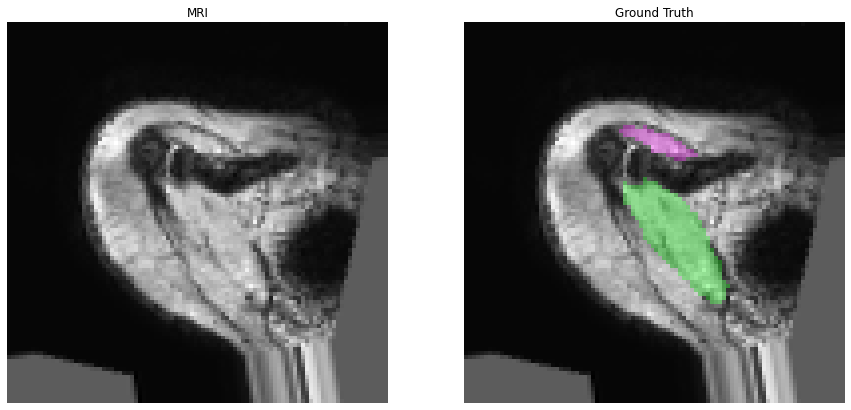

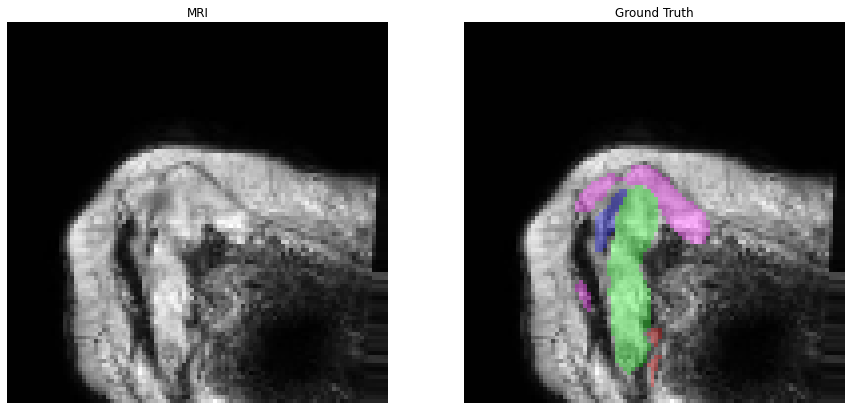

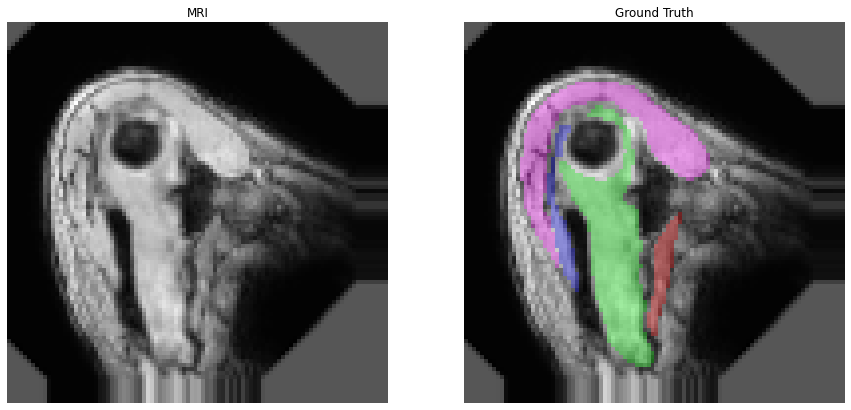

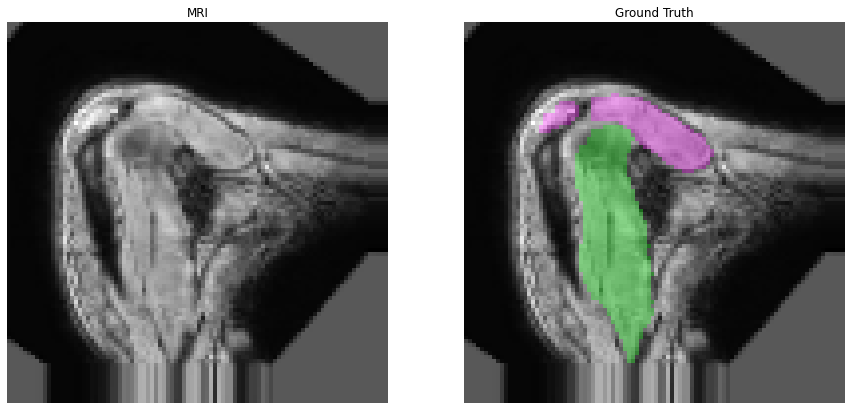

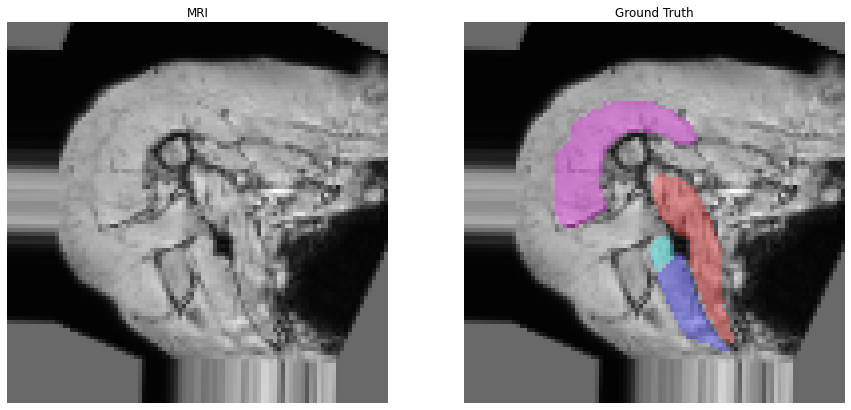

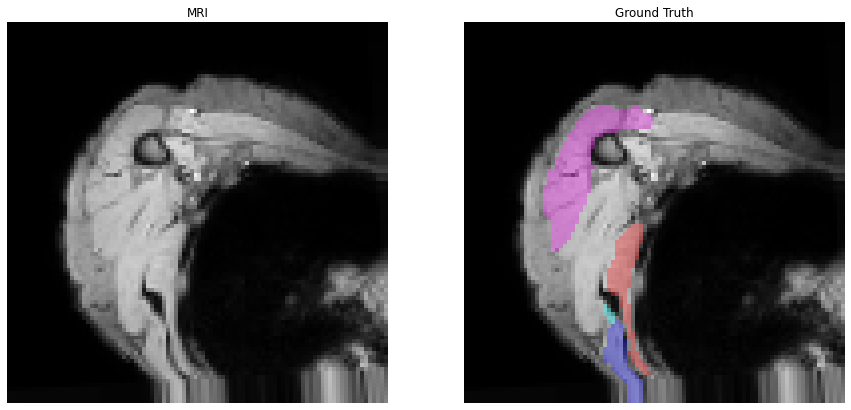

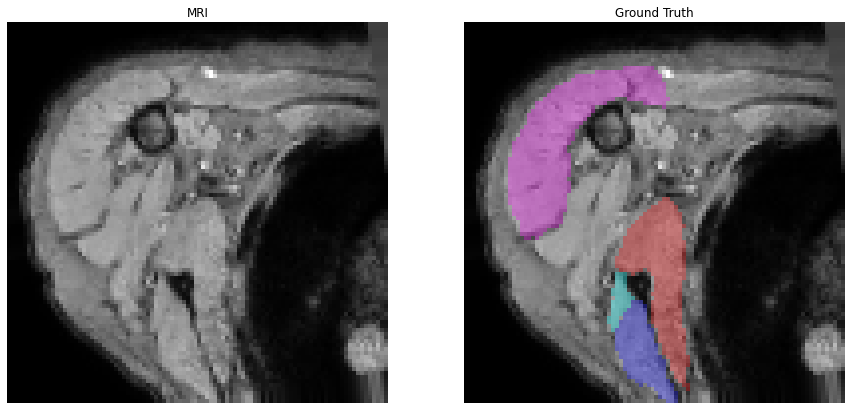

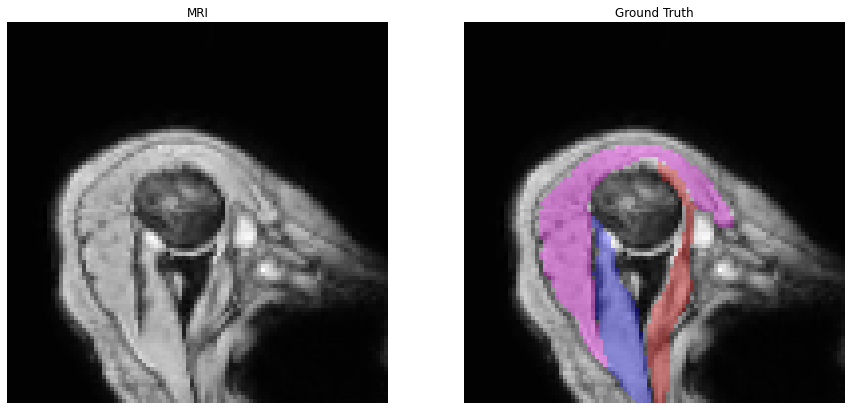

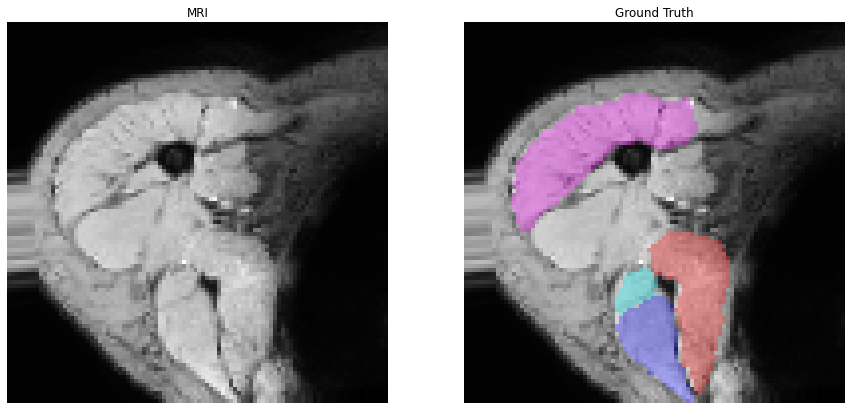

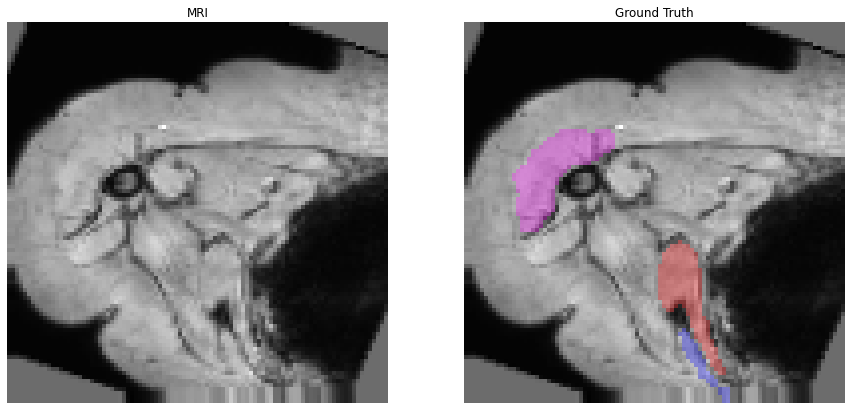

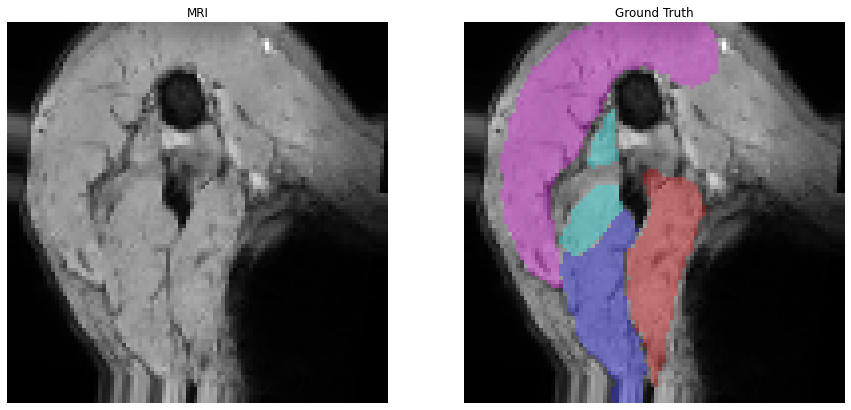

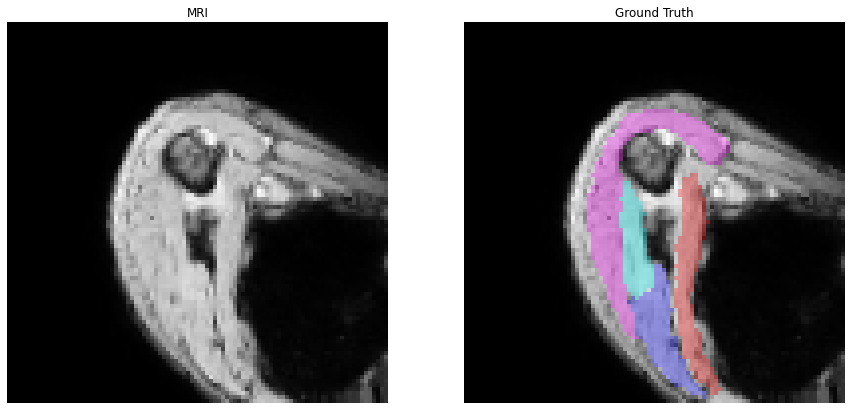

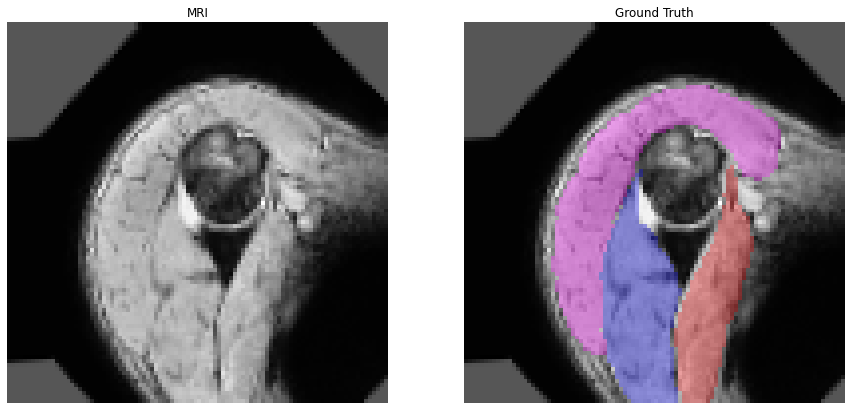

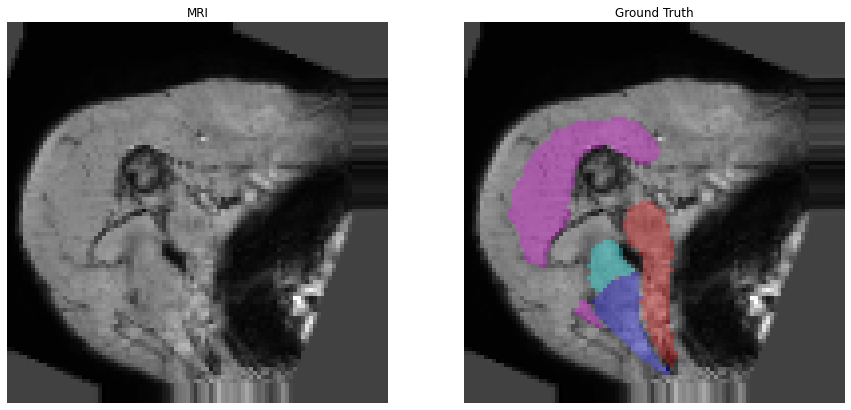

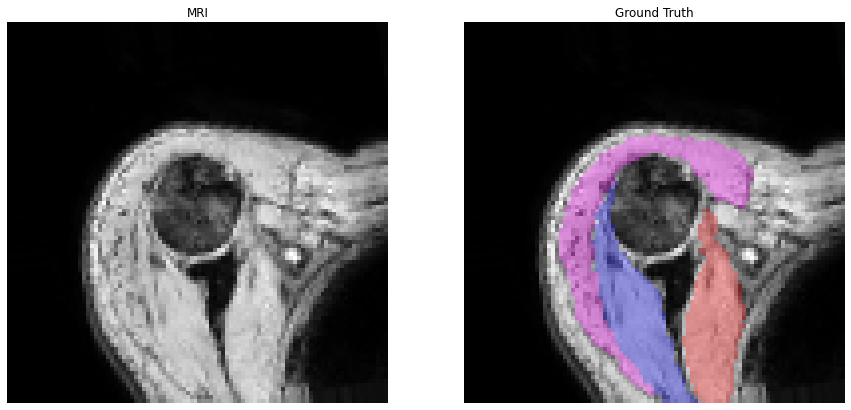

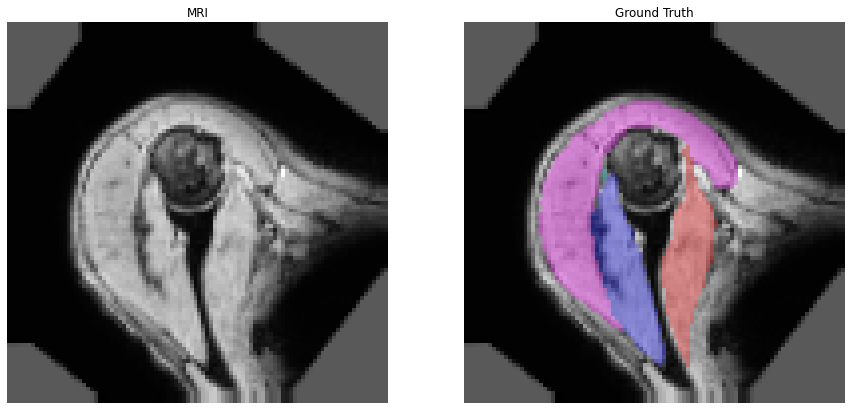

In [15]:
if JUPYTER_DISPLAY_ON == True:
    plot_overlay_segmentation(X, y)

## <span style="color:brown"> **5- Network and training**

## <span style="color:brown"> 5.1- Initialize network

### Import needed functions and reset the TF graph (safer, if you want to tune the model)

In [18]:
! pip install sklearn

     |████████████████████████████████| 30.8 MB 3.5 MB/s eta 0:00:01
     |████████████████████████████████| 306 kB 128.9 MB/s eta 0:00:01
  Created wheel for sklearn: filename=sklearn-0.0-py2.py3-none-any.whl size=1310 sha256=9d8d6f34f5f41a6de0a5a3ab3e086b953ebd877be6772944dd0ee62e679849fe
  Stored in directory: /home/jovyan/.cache/pip/wheels/e4/7b/98/b6466d71b8d738a0c547008b9eb39bf8676d1ff6ca4b22af1c
Successfully built sklearn


In [19]:
from keras_unet.models import custom_unet, xception_unet, lowfeaturedecoder_unet
from keras_unet.losses import dice_loss
from keras_unet.hausdorff_loss import Weighted_Hausdorff_loss

from tensorflow.keras import models
from tensorflow.keras import regularizers

### Create model

In [20]:
print(" input_shape : ", input_shape)

if 'model' in locals(): 
    print("deleting model")
    del model
    
model = custom_unet(
    input_shape,
    use_batch_norm=BATCHNORM_ON,  
    num_classes=y_train[0].shape[-1],
    filters=NBFILTERS_L1_UNET, 
    dropout=DROPOUT_RATE,
    num_layers=NBLAYERS_UNET,
    kernel_size=KERNEL_SIZE,
    cnn_activation=CNN_ACTIVATION,
    output_activation='softmax',
    kernel_regularizer=None # regularizers.l1(0.001)  # =None   for no regularization
    )     

 input_shape :  (96, 96, 1)


In [21]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 96, 96, 1)]  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 96, 96, 32)   320         input_1[0][0]                    
__________________________________________________________________________________________________
spatial_dropout2d (SpatialDropo (None, 96, 96, 32)   0           conv2d[0][0]                     
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 96, 96, 32)   9248        spatial_dropout2d[0][0]          
______________________________________________________________________________________________

## <span style="color:brown"> 5.2- Compile the model

### Create callbacks for interactions during training

In [22]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, TensorBoard

print("model_filename : ", model_filename)


callback_checkpoint = ModelCheckpoint(
    model_filename, 
    verbose=1, 
    monitor='val_dice_coef', #'val_loss'
    mode ='max', # use 'min' or 'auto' if val_loss
    save_best_only=True,
)

callback_earlystopping = EarlyStopping(
    monitor='val_dice_coef', #'val_loss'
    mode ='max', # use 'min' or 'auto' if val_loss
    patience=NBPATIENCE_EPOCHS,
    restore_best_weights=True  # at the end of fitting, restore best model weights 
)

logdir = "./logs/scalars/" + model_name + '_' + datetime.now().strftime("%Y-%m-%d_%Hh%M'")
print("logdir : ", logdir)
callback_tensorbooard = TensorBoard(
    log_dir=logdir, profile_batch=0
)

model_filename :  ./trained_model/Unet_1i_f32_l5_k3_do0.1_actrelu_b16_Std_input96.h5
logdir :  ./logs/scalars/Unet_1i_f32_l5_k3_do0.1_actrelu_b16_Std_2022-07-06_19h52'


### Compile the model

i.e. : Set optimization algorithm, loss, metrics, ...

In [23]:
from tensorflow.keras.optimizers import Adam, SGD, RMSprop
from keras_unet.metrics import dice_coef, iou, iou_thresholded
from keras_unet.losses import dice_loss, adaptive_loss
from tensorflow.keras.callbacks import TensorBoard

initial_learning_rate = 0.001

# Optional scheduler to decrease learning rate according iterations or epoches
#lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
#    initial_learning_rate,
#    decay_steps=10000,
#    decay_rate=0.96,
#    staircase=True)

model.compile(
    loss=adaptive_loss,
    #loss='categorical_crossentropy',   # <- other loss you can test
    
    optimizer=RMSprop(learning_rate=initial_learning_rate, rho=0.9, momentum=0.8, epsilon=1e-07, centered=True),
    #optimizer=RMSprop(learning_rate=lr_schedule, rho=0.9, momentum=0.8, epsilon=1e-07, centered=True),     # <- other optimizer you can test
    #optimizer=SGD(learning_rate=initial_learning_rate, momentum=0.99),  # 0.01 
    #optimizer=Adam(learning_rate=initial_learning_rate),  # 0.0001
    
    metrics=[dice_coef]
)


## <span style="color:brown"> 5.3- Fit the model (train)

Watch evolution of loss on epoches and time elapsed per epoch.
If too long, you can stop the execution.

In [24]:
history = model.fit(
    X_train, y_train,  # use the 'original' images 
#    myiter,           # use the images augmented by generator
#    steps_per_epoch=NBSTEPS_PER_EPOCH,  # uncomment when using 'myiter' (a data generator)
    batch_size=BATCH_SIZE,
    epochs=NBEPOCHS,
    validation_data=(X_val, y_val), 
    shuffle=True,
    verbose=1,
    callbacks=[callback_earlystopping, callback_checkpoint, callback_tensorbooard]
)

Epoch 1/20
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
41/41 [==============================] - 85s 1s/step - loss: 4.7174 - dice_coef: 0.1546 - val_loss: 0.5600 - val_dice_coef: 0.1875

Epoch 00001: val_dice_coef improved from -inf to 0.18747, saving model to ./trained_model/Unet_1i_f32_l5_k3_do0.1_actrelu_b16_Std_input96.h5
Epoch 2/20
41/41 [==============================] - 3s 82ms/step - loss: 0.5391 - dice_coef: 0.1971 - val_loss: 0.44

## <span style="color:brown"> 5.4- Plot training and validation history

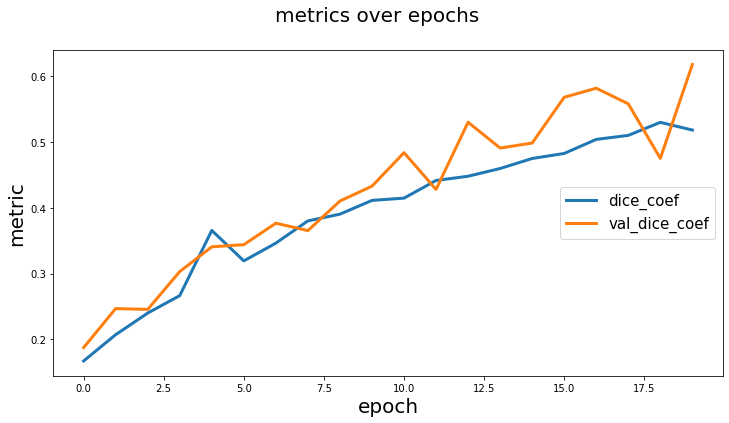

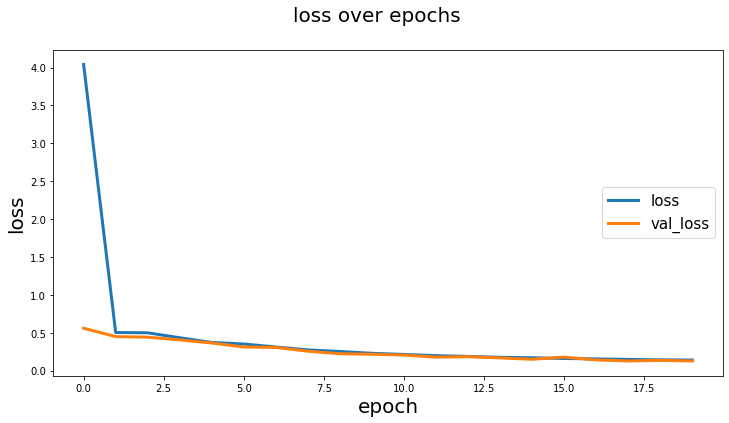

In [25]:
from keras_unet.visualization import plot_segm_history

plot_segm_history(history,  metrics=['dice_coef', 'val_dice_coef'])

## <span style="color:brown"> 5.5- Plot training and validation during training with Tensorboard (NOT ON SATURN CLOUD)

You can use tensorboard to watch loss and metric evolutions during training.
To do so you can :
  1. start a terminal in jupyter lab (File -> New launcher then 'Terminal'
  2. in this terminal execute : ```$ tensorboard  --logdir ./logs/scalars/  ```
    

## <span style="color:brown"> **6- Verify the model**

## <span style="color:brown"> 6.1- Plot original + ground truth + pred + overlay (pred on top of original)

In [26]:
y_pred = model.predict(X_val, batch_size=1, verbose=1) # GPU Size
loss, dice_coef = model.evaluate(x=X_val, y=y_val, batch_size=1, verbose=1) # 
print(f"loss : {loss}   Dice_coeff : {dice_coef}")

72/72 [==============================] - 1s 7ms/step - loss: 0.1280 - dice_coef: 0.6125
loss : 0.12795354425907135   Dice_coeff : 0.6125462651252747


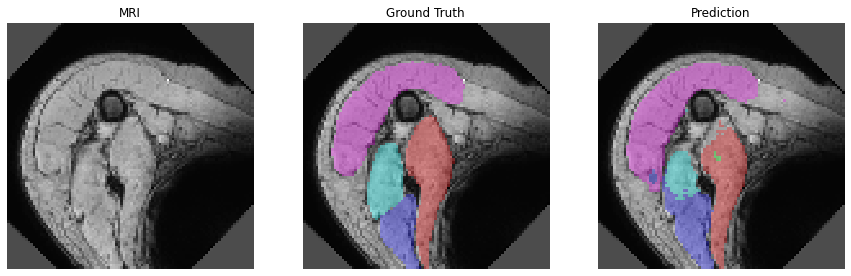

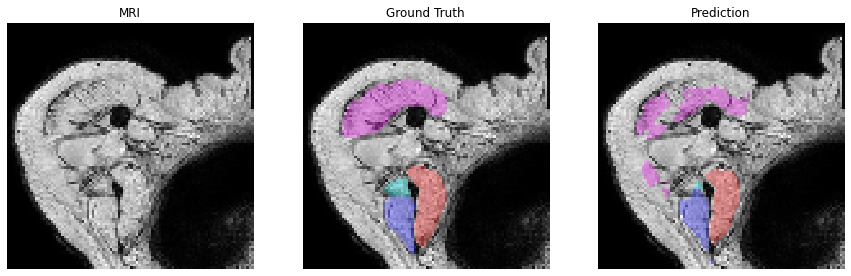

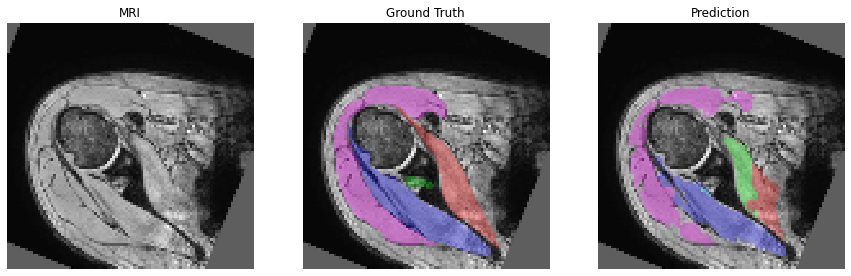

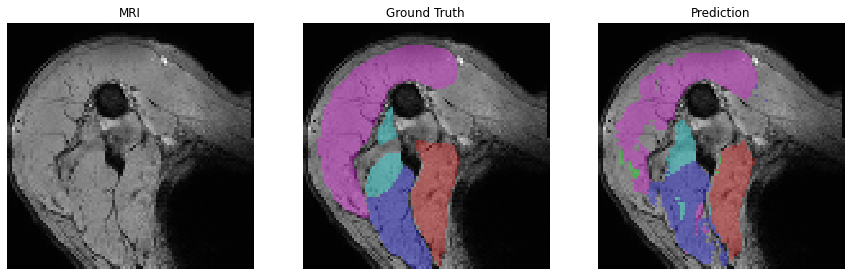

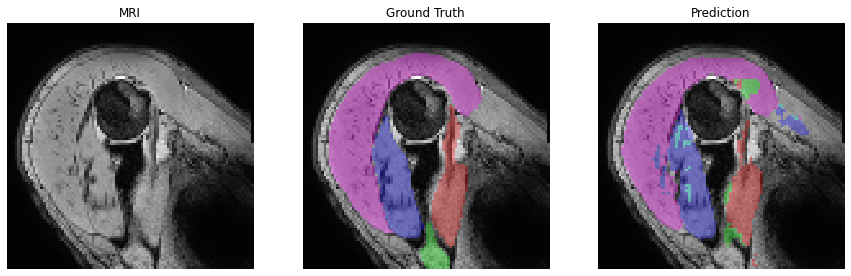

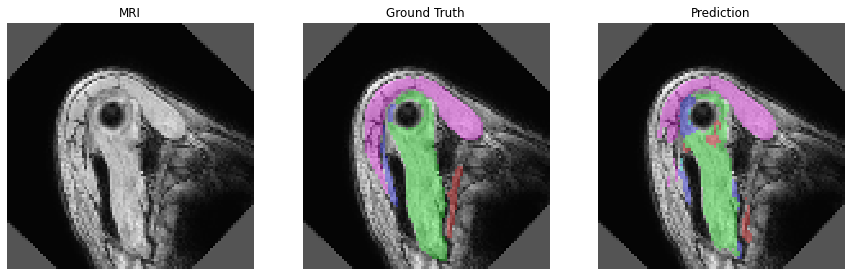

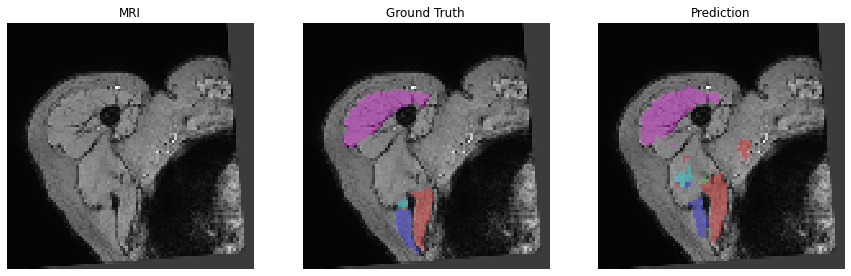

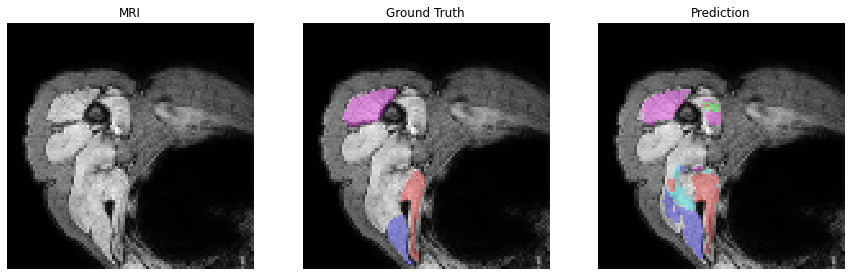

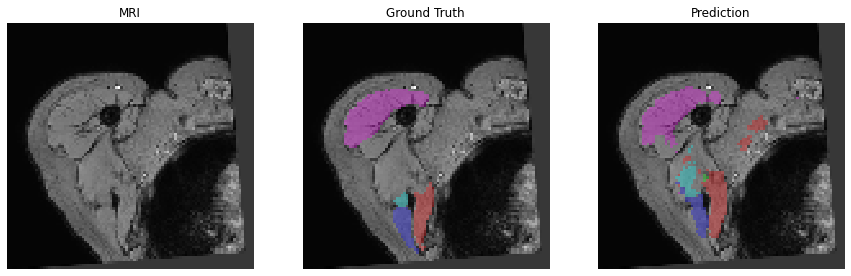

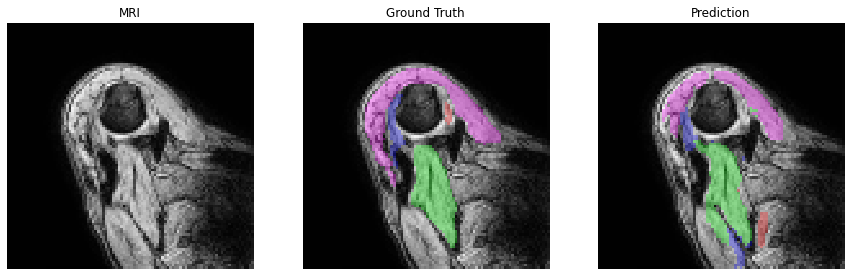

In [27]:
N_b = 0
N_e = 10
plot_compare_segmentation(X_val_e8[N_b:N_e], y_val[N_b:N_e], y_pred[N_b:N_e], " ", spacing=(1,1), step=1)

## <span style="color:red"> Questions

- Run 20 more epoches and display curves and results again (... run the cells after §5.3). Are the results better ?
- And 20 more ? 
- Train this network to have a DICE greater than 0.90. 
- Are the segmentation results convincing on the validation images ? Is this assessment correct?
- Execute the next 2 cells : evaluation is performed on the test set ...

## <span style="color:brown"> 6.2- Inference on test images

In [28]:
y_pred = model.predict(X_test, batch_size=1, verbose=1) # GPU Size
loss, dice_coef = model.evaluate(x=X_test, y=y_test, batch_size=1, verbose=1) # 
print(f"loss : {loss}   Dice_coeff : {dice_coef}")

208/208 [==============================] - 1s 7ms/step - loss: 0.1481 - dice_coef: 0.6211
loss : 0.14809861779212952   Dice_coeff : 0.621096670627594


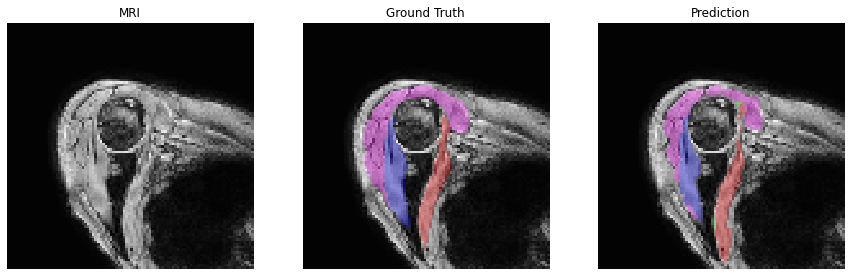

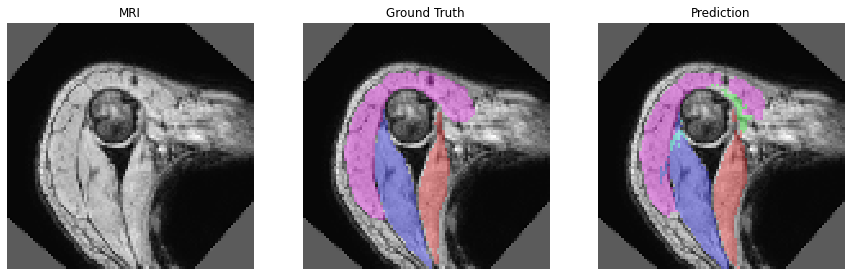

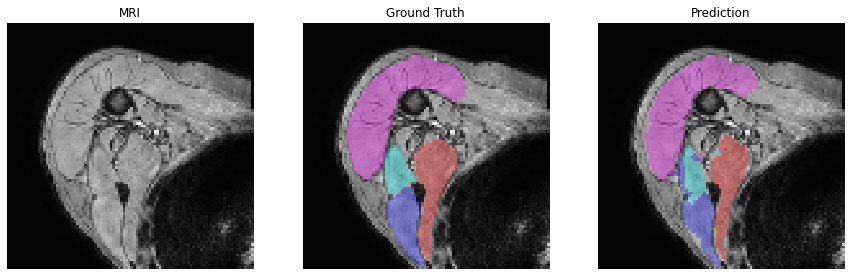

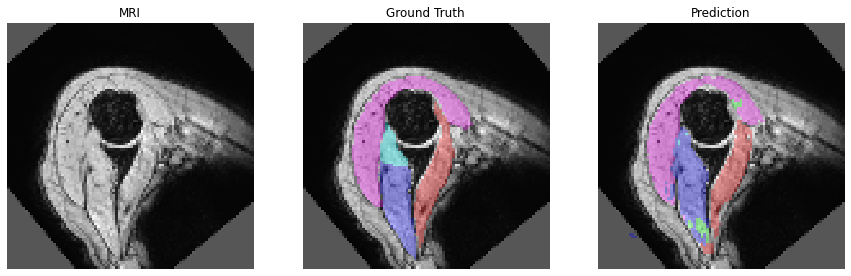

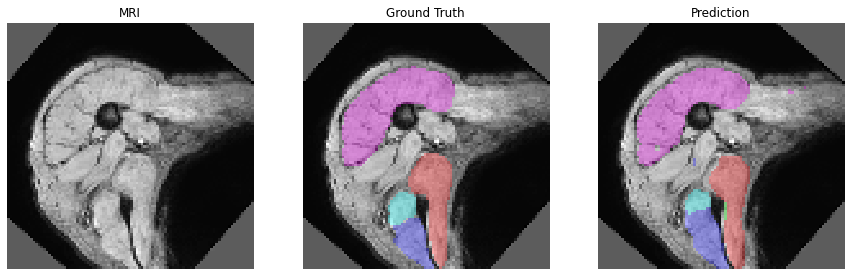

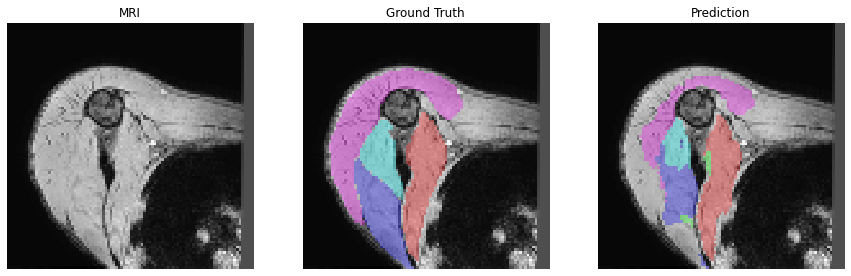

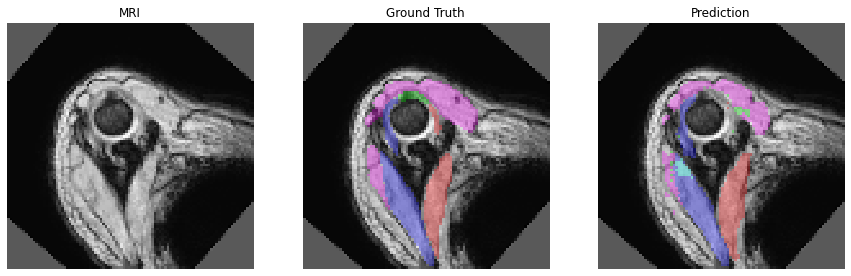

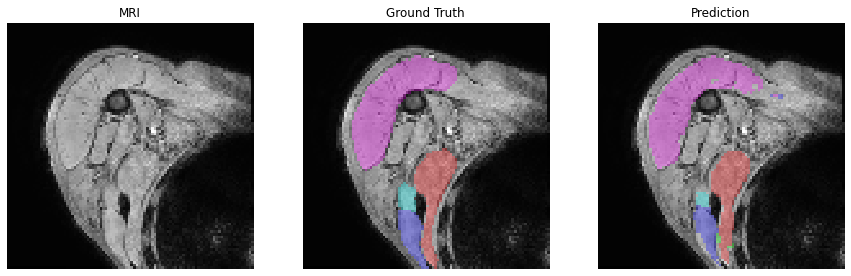

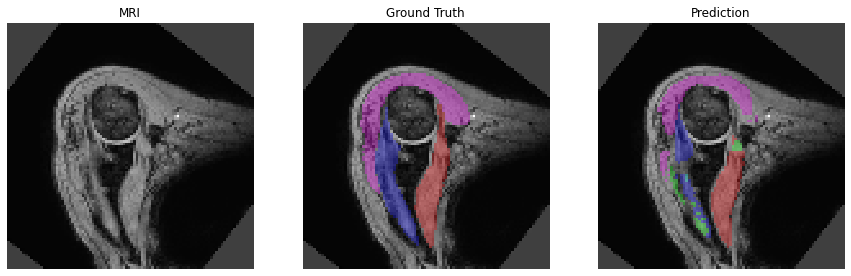

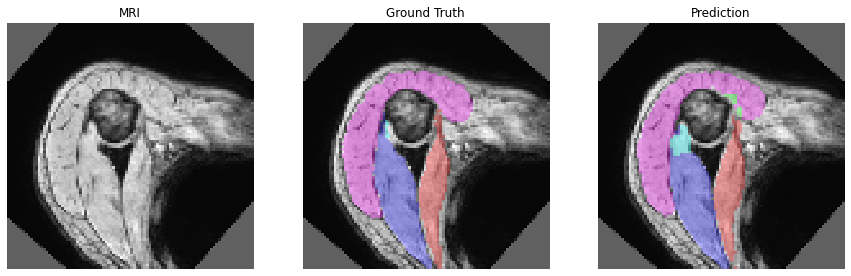

In [29]:
N_b = 0
N_e = 10
plot_compare_segmentation(X_test[N_b:N_e], y_test[N_b:N_e], y_pred[N_b:N_e], " ", spacing=(1,1), step=1)

## <span style="color:red"> Questions

- Optimize the training paramters to improve segmentation results (according the validation set iou thresholded value): regularizations, data sets size, hyper parameters (you can enable regularizations (drop out, Batch Norm, L1 or L2 on weights). Note that you can't check all configurations, so plan tests with your collegues ! (and have a look at AutoML)
    
- Ok, the above training is long ;) So during training, display some information using Tensorboard: model shape and real time training curves.
    
- What is early stopping and what it should avoid? Discuss the evolution of losses and metrcis during training.

## <span style="color:brown"> **7- Accessing the learned filters**
    
For understanding effect of layers, it can be of interest to display filters learned by the network.

In [30]:
print(" -> number of layers : ", len(model.layers) )
for a in range(1,len(model.layers)):
    print(f" index : {a}, layer name : {model.layers[a].name}") 

 -> number of layers :  51
 index : 1, layer name : conv2d
 index : 2, layer name : spatial_dropout2d
 index : 3, layer name : conv2d_1
 index : 4, layer name : spatial_dropout2d_1
 index : 5, layer name : max_pooling2d
 index : 6, layer name : conv2d_2
 index : 7, layer name : spatial_dropout2d_2
 index : 8, layer name : conv2d_3
 index : 9, layer name : spatial_dropout2d_3
 index : 10, layer name : max_pooling2d_1
 index : 11, layer name : conv2d_4
 index : 12, layer name : spatial_dropout2d_4
 index : 13, layer name : conv2d_5
 index : 14, layer name : spatial_dropout2d_5
 index : 15, layer name : max_pooling2d_2
 index : 16, layer name : conv2d_6
 index : 17, layer name : spatial_dropout2d_6
 index : 18, layer name : conv2d_7
 index : 19, layer name : spatial_dropout2d_7
 index : 20, layer name : max_pooling2d_3
 index : 21, layer name : conv2d_8
 index : 22, layer name : spatial_dropout2d_8
 index : 23, layer name : conv2d_9
 index : 24, layer name : spatial_dropout2d_9
 index : 2

In [31]:
N_l = 1 # Remember that some layers have no weights !
print("-> Get config : ", model.layers[N_l].get_config())  # get whole information of the layer (config of the layer)

-> Get config :  {'name': 'conv2d', 'trainable': True, 'dtype': 'float32', 'filters': 32, 'kernel_size': (3, 3), 'strides': (1, 1), 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': (1, 1), 'groups': 1, 'activation': 'relu', 'use_bias': True, 'kernel_initializer': {'class_name': 'HeNormal', 'config': {'seed': None}}, 'bias_initializer': {'class_name': 'Zeros', 'config': {}}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}


In [32]:
print("-> Get shape : ", model.layers[N_l].get_weights()[0].shape) #ok this line works only if some weights exist (X,Y,C,Neurons)
w = model.layers[N_l].get_weights()[0][:,:,0,:]
print(w.shape[2])

-> Get shape :  (3, 3, 1, 32)
32


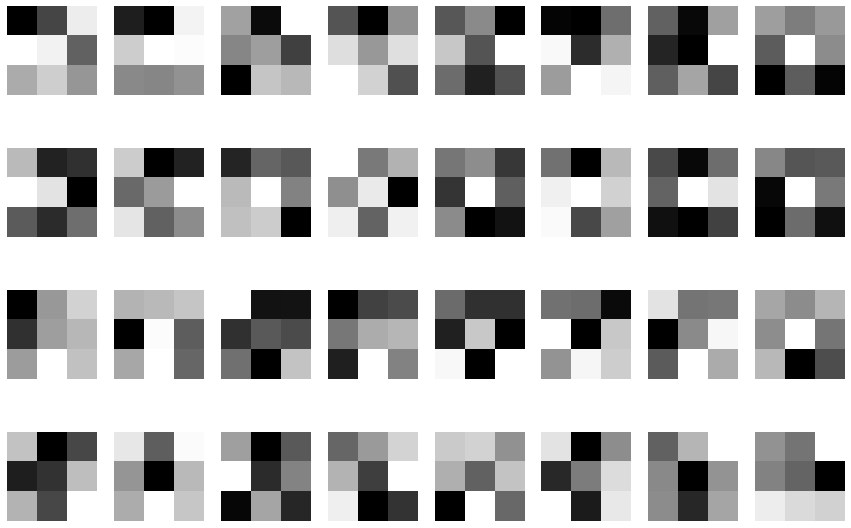

In [33]:
nb_filters = w.shape[2]
nb_filters_per_line = 8   # 
if nb_filters > 256: nb_filters = 256
if nb_filters < 9: nb_filters_per_line = nb_filters
#assert nb_filters < 256
plt.subplots(nb_filters//nb_filters_per_line,nb_filters_per_line,figsize=(15,10))
for i in range(1,nb_filters+1,1):  
    plt.subplot(nb_filters//nb_filters_per_line,nb_filters_per_line,i) # current plot is i
    plt.imshow(w[:,:,i-1], interpolation='none', cmap='gray')
    plt.axis('off')

## <span style="color:red"> Question
  
- Visualize and discuss the filters of the first CNN after the first maxpooling (conv2d_3 layer). Justify its shape.

## <span style="color:brown"> **8- Observing the intermediate images**
    
Intermediate images are images at the output of layers.
This task can be done efficiently using a second network that just copies all outputs of our network (the variable is *model*) to allow us displaying the activations.

In [34]:
layer_outputs = [layer.output for layer in model.layers[1:]]  # skip input for fed problem
print( len(layer_outputs) )
# Extracts the outputs 
activation_model  = models.Model(inputs=model.input, outputs=layer_outputs) # Creates a model that will return these outputs, given the model input

50


Here we select an image (in the validation set... it can be changed!)

In [35]:
Index_img_to_display = 9
print(X_val_e8[Index_img_to_display:Index_img_to_display+1,:,:,:].shape)
activations = activation_model.predict(X_val_e8[Index_img_to_display:Index_img_to_display+1,:,:,:])

(1, 96, 96, 1)


Here we select an activation output. For convenience, indexes of layers have been preserved from 0 to N (0 means input and is not mapped to this model) 

In [36]:
Index_Output_Layer = N_l
first_layer_activation = activations[Index_Output_Layer - 1]
print(first_layer_activation.shape)

(1, 96, 96, 32)


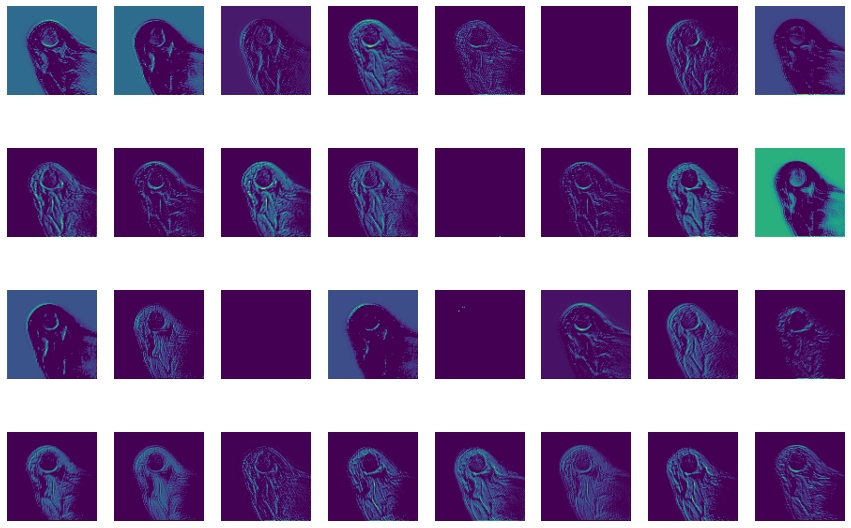

In [37]:
#plt.figure(figsize=(10,10))
#plt.imshow(first_layer_activation[0, :, :, 2], cmap='viridis')  

nb_filters =first_layer_activation.shape[3]
nb_filters_per_line = 8   # 
if nb_filters > 256: nb_filters = 256
if nb_filters < 9: nb_filters_per_line = nb_filters
#assert nb_filters < 256
plt.subplots(nb_filters//nb_filters_per_line,nb_filters_per_line,figsize=(15,10))
for i in range(1,nb_filters+1,1):  
    plt.subplot(nb_filters//nb_filters_per_line,nb_filters_per_line,i) # current plot is i
    plt.imshow(first_layer_activation[0, :, :, i-1], interpolation='bilinear', cmap='viridis')
    plt.axis('off')

## <span style="color:red"> Questions
  
- Visualize and discuss the filters conv2d_3 layer (the first CNN after the first maxpooling). Justify its shape.
- Visualize and discuss the last filter.


## <span style="color:red"> Questions, to finish ... 
 
- Modify the network to use the 3 MRI sequences as input (e8, e5 and e2). Follow the training with tensorboard. Is DICE improved?

- Modify the code to use the Xception_unet with ADAM optimizer. First change the __model_filename__ string to facilitate comparisons with previous training.
 
- How much time to manual segment an image ? Why it is critical to have good (expert, consistent) annotated images? With no more new data, what can be done to __augment__ our train data set?


### Tensorboard (reminder)

In [ ]:
# not necessary on floydhub

# %load_ext tensorboard
# tensorboard --host 134.214.236.10 --logdir ./logs/scalars/                ##  --port --bind_all

# http://134.214.236.10:6006

(645, 96, 96, 3)
Epoch 1/20


ValueError: in user code:

    /srv/conda/envs/saturn/lib/python3.9/site-packages/tensorflow/python/keras/engine/training.py:805 train_function  *
        return step_function(self, iterator)
    /srv/conda/envs/saturn/lib/python3.9/site-packages/tensorflow/python/keras/engine/training.py:795 step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    /srv/conda/envs/saturn/lib/python3.9/site-packages/tensorflow/python/distribute/distribute_lib.py:1259 run
        return self._extended.call_for_each_replica(fn, args=args, kwargs=kwargs)
    /srv/conda/envs/saturn/lib/python3.9/site-packages/tensorflow/python/distribute/distribute_lib.py:2730 call_for_each_replica
        return self._call_for_each_replica(fn, args, kwargs)
    /srv/conda/envs/saturn/lib/python3.9/site-packages/tensorflow/python/distribute/distribute_lib.py:3417 _call_for_each_replica
        return fn(*args, **kwargs)
    /srv/conda/envs/saturn/lib/python3.9/site-packages/tensorflow/python/keras/engine/training.py:788 run_step  **
        outputs = model.train_step(data)
    /srv/conda/envs/saturn/lib/python3.9/site-packages/tensorflow/python/keras/engine/training.py:754 train_step
        y_pred = self(x, training=True)
    /srv/conda/envs/saturn/lib/python3.9/site-packages/tensorflow/python/keras/engine/base_layer.py:1012 __call__
        outputs = call_fn(inputs, *args, **kwargs)
    /srv/conda/envs/saturn/lib/python3.9/site-packages/tensorflow/python/keras/engine/functional.py:424 call
        return self._run_internal_graph(
    /srv/conda/envs/saturn/lib/python3.9/site-packages/tensorflow/python/keras/engine/functional.py:560 _run_internal_graph
        outputs = node.layer(*args, **kwargs)
    /srv/conda/envs/saturn/lib/python3.9/site-packages/tensorflow/python/keras/engine/base_layer.py:998 __call__
        input_spec.assert_input_compatibility(self.input_spec, inputs, self.name)
    /srv/conda/envs/saturn/lib/python3.9/site-packages/tensorflow/python/keras/engine/input_spec.py:255 assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer conv2d is incompatible with the layer: expected axis -1 of input shape to have value 1 but received input with shape (None, 96, 96, 3)


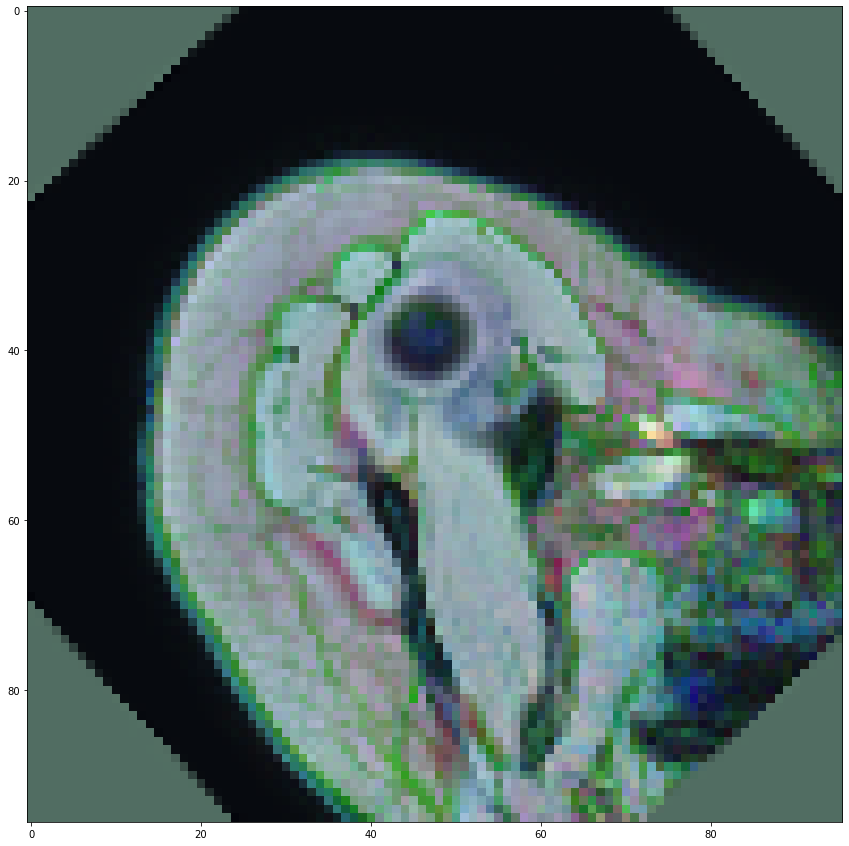

In [38]:
# hints for usage of 3 MRI as input
input_shape = (IMG_SIZE, IMG_SIZE, 3) # see the "3" instead of 1

concat_train = tf.keras.layers.Concatenate()([X_train_e8, X_train_e5, X_train_e2])
concat_val = tf.keras.layers.Concatenate()([X_val_e8, X_val_e5, X_val_e2])
print(concat_train.shape)
plt.imshow(concat_train[0]) # display in color :p


history = model.fit(
    concat_train, y_train,
    batch_size=BATCH_SIZE,
    epochs=NBEPOCHS,
    validation_data=(concat_val, y_val),
    shuffle=True,
    verbose=1,
    callbacks=[ callback_earlystopping, callback_checkpoint, callback_tensorbooard]
)


y_pred = model.predict(concat_val, batch_size=1, verbose=1) # GPU Size
loss, dice_coef = model.evaluate(x=concat_val, y=y_val, batch_size=1, verbose=1) # 
print(f"loss : {loss}   Dice_coeff : {dice_coef}")
print(y_pred.shape)



In [39]:
# hints for Xception Unet

model = xception_unet(
    input_shape,
    num_classes=y_train[0].shape[-1],
    filters=NBFILTERS_L1_UNET, 
    output_activation='softmax'
    )
